In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt
import spatial_maps as sm

from tqdm import tqdm
from models import FFGC
from plotting_functions import *

import scipy

In [2]:
## Training parameters
train_steps = 50000
bs = 128 # batch size

In [3]:
# instantiate feedforward model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

array([0.001     , 0.00112762, 0.00127046, 0.00143145, 0.00161263,
       0.00181737, 0.00204833, 0.00230808, 0.00260129, 0.00293233,
       0.00330501, 0.00372575, 0.00419986, 0.00473508, 0.00533861,
       0.00601951, 0.00678778, 0.00765519, 0.00863424, 0.0097397 ,
       0.01098817, 0.0123988 , 0.01399297, 0.01579534, 0.01783394,
       0.02014083, 0.02275278, 0.02571204, 0.02906702, 0.03287376,
       0.03719693, 0.04211158, 0.04770511, 0.05407959, 0.0613547 ,
       0.06967145, 0.07919677, 0.09012897, 0.10270503, 0.11720897,
       0.13398226, 0.15343552, 0.17606028, 0.20243703, 0.23323038,
       0.26915146, 0.31084967, 0.35867748, 0.41229392, 0.47022416,
       0.52977584, 0.58770608, 0.64132252, 0.68915033, 0.73084854,
       0.76676962, 0.79756297, 0.82393972, 0.84656448, 0.86601774,
       0.88279103, 0.89729497, 0.90987103, 0.92080323, 0.93032855,
       0.9386453 , 0.94592041, 0.95229489, 0.95788842, 0.96280307,
       0.96712624, 0.97093298, 0.97428796, 0.97724722, 0.97985

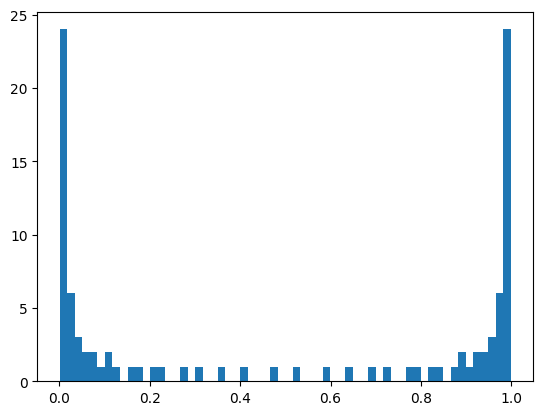

In [4]:
from scipy.integrate import cumtrapz

def inverse_transform_sampling(prob_density_func, num_samples):
    # Create an array across the interval [0, 1]
    x = np.linspace(0.001, 0.999, 10000)

    # Calculate the cumulative distribution function (CDF)
    cdf = cumtrapz(prob_density_func(x), x)
    cdf = np.insert(cdf, 0, 0)

    # Use the CDF to get the inverse CDF
    inverse_cdf = np.interp(np.linspace(0, cdf[-1], num_samples), cdf, x)

    return inverse_cdf

# alphas = inverse_transform_sampling(lambda x: 1/(x*(1-x)), 100)
alphas = inverse_transform_sampling(lambda x: (1-x)/x + x/(1-x), 100)
plt.hist(alphas, bins = 60)
alphas

In [5]:
alphas = np.linspace(0.85, 0.94, 100)
# alphas = 1-np.geomspace(0.001,1,30)
grid_scores = []
for alpha in tqdm(alphas):
    print(f'Alpha: {alpha}')
    model = FFGC(alpha = alpha)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
    # Train model
    for i in range(train_steps-len(model.total_loss_history)):
        r = torch.rand((bs, 2), device = device)*4*np.pi - 2*np.pi
        loss = model.train_step(inputs = r, labels = r, optimizer = optimizer)

    # Plot loss history
    # fig,axs = plt.subplots(1,3,figsize=(9,3))
    # axs[0].semilogy(np.array(model.total_loss_history)-model.loss_minima(), label = 'Total loss', color = 'black')
    # axs[1].semilogy(np.array(model.capacity_loss_history)-model.loss_minima(), label = 'Capacity loss', color = 'red')
    # axs[2].semilogy(model.similarity_loss_history, label = 'Similarity loss', color = 'blue')
    # fig.tight_layout()
    # fig.legend()
    # plt.savefig(f'./gridsearch/ffgc_loss_alpha_{alpha}.png')
    # plt.close()

    # evaluate on 64x64 grid
    res = 64
    x = np.linspace(-1, 1, res)*2*np.pi
    y = np.linspace(-1, 1, res)*2*np.pi
    xx, yy = np.meshgrid(x,y)
    r = np.stack([xx.ravel(), yy.ravel()], axis = -1)
    gs = model(torch.tensor(r.astype("float32"),device = device))
    gs = gs.detach().cpu().numpy()
    gs = gs.T.reshape(-1,res,res)

    # plot spatial map
    # multiimshow(gs[:25], figsize=(10,10), normalize=False);
    # plt.tight_layout()
    # plt.savefig(f'./gridsearch/ffgc_spatial_map_alpha_{alpha}.png')
    # plt.close()

    # Gridscore
    grid_score = np.array([sm.gridness(gs[i]) for i in range(len(gs))])
    grid_scores.append(grid_score)

# Save grid scores
grid_scores = np.array(grid_scores)
np.save('./gridsearch/ffgc_grid_scores.npy', grid_scores)
np.save('./gridsearch/ffgc_grid_scores_alphas.npy', alphas)

  0%|          | 0/100 [00:00<?, ?it/s]

Alpha: 0.85


c:\Users\kingt\anaconda3\envs\torch2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  1%|          | 1/100 [01:15<2:05:06, 75.82s/it]

Alpha: 0.8509090909090908


  2%|▏         | 2/100 [02:31<2:03:22, 75.53s/it]

Alpha: 0.8518181818181818


  3%|▎         | 3/100 [03:45<2:01:18, 75.04s/it]

Alpha: 0.8527272727272727


  4%|▍         | 4/100 [05:00<1:59:54, 74.95s/it]

Alpha: 0.8536363636363636


c:\Users\kingt\anaconda3\envs\torch2\lib\site-packages\spatial_maps\tools.py:41: RuntimeWarning: invalid value encountered in true_divide
  arr1 = (arr1 - np.mean(a_)) / (np.std(a_) * len(a_))
c:\Users\kingt\anaconda3\envs\torch2\lib\site-packages\spatial_maps\tools.py:42: RuntimeWarning: invalid value encountered in true_divide
  arr2 = (arr2 - np.mean(v_)) / np.std(v_)
c:\Users\kingt\anaconda3\envs\torch2\lib\site-packages\numpy\core\fromnumeric.py:86: UserWarning: Warning: converting a masked element to nan.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
  5%|▌         | 5/100 [06:15<1:58:29, 74.84s/it]

Alpha: 0.8545454545454545


  6%|▌         | 6/100 [07:29<1:57:12, 74.81s/it]

Alpha: 0.8554545454545455


  7%|▋         | 7/100 [08:44<1:55:56, 74.80s/it]

Alpha: 0.8563636363636363


  8%|▊         | 8/100 [09:58<1:54:22, 74.60s/it]

Alpha: 0.8572727272727273


  9%|▉         | 9/100 [11:13<1:53:13, 74.65s/it]

Alpha: 0.8581818181818182


 10%|█         | 10/100 [12:28<1:51:55, 74.62s/it]

Alpha: 0.859090909090909


 11%|█         | 11/100 [13:42<1:50:38, 74.58s/it]

Alpha: 0.86


 12%|█▏        | 12/100 [14:57<1:49:34, 74.71s/it]

Alpha: 0.8609090909090908


 13%|█▎        | 13/100 [16:11<1:48:10, 74.61s/it]

Alpha: 0.8618181818181818


 14%|█▍        | 14/100 [17:26<1:47:07, 74.74s/it]

Alpha: 0.8627272727272727


 15%|█▌        | 15/100 [18:41<1:45:37, 74.56s/it]

Alpha: 0.8636363636363636


 16%|█▌        | 16/100 [19:55<1:44:20, 74.53s/it]

Alpha: 0.8645454545454545


 17%|█▋        | 17/100 [21:10<1:43:19, 74.70s/it]

Alpha: 0.8654545454545455


 18%|█▊        | 18/100 [22:25<1:41:56, 74.59s/it]

Alpha: 0.8663636363636363


 19%|█▉        | 19/100 [23:39<1:40:51, 74.71s/it]

Alpha: 0.8672727272727272


 20%|██        | 20/100 [24:54<1:39:33, 74.67s/it]

Alpha: 0.8681818181818182


 21%|██        | 21/100 [26:09<1:38:26, 74.76s/it]

Alpha: 0.869090909090909


 22%|██▏       | 22/100 [27:24<1:37:11, 74.76s/it]

Alpha: 0.87


 23%|██▎       | 23/100 [28:38<1:35:50, 74.68s/it]

Alpha: 0.8709090909090909


 24%|██▍       | 24/100 [29:53<1:34:39, 74.73s/it]

Alpha: 0.8718181818181818


 25%|██▌       | 25/100 [31:08<1:33:23, 74.71s/it]

Alpha: 0.8727272727272727


 26%|██▌       | 26/100 [32:21<1:31:27, 74.15s/it]

Alpha: 0.8736363636363637


 27%|██▋       | 27/100 [33:33<1:29:36, 73.65s/it]

Alpha: 0.8745454545454545


 28%|██▊       | 28/100 [34:46<1:27:57, 73.30s/it]

Alpha: 0.8754545454545454


 29%|██▉       | 29/100 [35:58<1:26:34, 73.16s/it]

Alpha: 0.8763636363636363


 30%|███       | 30/100 [37:11<1:25:06, 72.94s/it]

Alpha: 0.8772727272727272


 31%|███       | 31/100 [38:24<1:23:53, 72.95s/it]

Alpha: 0.8781818181818182


 32%|███▏      | 32/100 [39:37<1:22:35, 72.88s/it]

Alpha: 0.879090909090909


 33%|███▎      | 33/100 [40:49<1:21:18, 72.81s/it]

Alpha: 0.88


 34%|███▍      | 34/100 [42:02<1:20:06, 72.83s/it]

Alpha: 0.8809090909090909


 35%|███▌      | 35/100 [43:15<1:18:48, 72.74s/it]

Alpha: 0.8818181818181818


 36%|███▌      | 36/100 [44:28<1:17:39, 72.81s/it]

Alpha: 0.8827272727272727


 37%|███▋      | 37/100 [45:40<1:16:22, 72.74s/it]

Alpha: 0.8836363636363636


 38%|███▊      | 38/100 [46:53<1:15:11, 72.77s/it]

Alpha: 0.8845454545454545


 39%|███▉      | 39/100 [48:06<1:14:03, 72.85s/it]

Alpha: 0.8854545454545454


 40%|████      | 40/100 [49:19<1:12:45, 72.76s/it]

Alpha: 0.8863636363636364


 41%|████      | 41/100 [50:32<1:11:36, 72.82s/it]

Alpha: 0.8872727272727272


 42%|████▏     | 42/100 [51:44<1:10:13, 72.65s/it]

Alpha: 0.8881818181818182


 43%|████▎     | 43/100 [52:57<1:09:01, 72.66s/it]

Alpha: 0.889090909090909


 44%|████▍     | 44/100 [54:09<1:07:53, 72.75s/it]

Alpha: 0.89


 45%|████▌     | 45/100 [55:22<1:06:38, 72.70s/it]

Alpha: 0.8909090909090909


 46%|████▌     | 46/100 [56:35<1:05:30, 72.79s/it]

Alpha: 0.8918181818181817


 47%|████▋     | 47/100 [57:48<1:04:15, 72.75s/it]

Alpha: 0.8927272727272727


 48%|████▊     | 48/100 [59:00<1:03:01, 72.72s/it]

Alpha: 0.8936363636363636


 49%|████▉     | 49/100 [1:00:13<1:01:53, 72.81s/it]

Alpha: 0.8945454545454545


 50%|█████     | 50/100 [1:01:26<1:00:40, 72.82s/it]

Alpha: 0.8954545454545454


 51%|█████     | 51/100 [1:02:39<59:30, 72.87s/it]  

Alpha: 0.8963636363636364


 52%|█████▏    | 52/100 [1:03:52<58:14, 72.81s/it]

Alpha: 0.8972727272727272


 53%|█████▎    | 53/100 [1:05:05<57:01, 72.80s/it]

Alpha: 0.8981818181818182


 54%|█████▍    | 54/100 [1:06:17<55:48, 72.80s/it]

Alpha: 0.899090909090909


 55%|█████▌    | 55/100 [1:07:30<54:31, 72.69s/it]

Alpha: 0.8999999999999999


 56%|█████▌    | 56/100 [1:08:43<53:22, 72.77s/it]

Alpha: 0.9009090909090909


 57%|█████▋    | 57/100 [1:09:56<52:08, 72.76s/it]

Alpha: 0.9018181818181817


 58%|█████▊    | 58/100 [1:11:08<50:57, 72.79s/it]

Alpha: 0.9027272727272727


 59%|█████▉    | 59/100 [1:12:21<49:46, 72.84s/it]

Alpha: 0.9036363636363636


 60%|██████    | 60/100 [1:13:34<48:32, 72.81s/it]

Alpha: 0.9045454545454545


 61%|██████    | 61/100 [1:14:47<47:22, 72.89s/it]

Alpha: 0.9054545454545454


 62%|██████▏   | 62/100 [1:16:00<46:08, 72.85s/it]

Alpha: 0.9063636363636364


 63%|██████▎   | 63/100 [1:17:13<44:56, 72.87s/it]

Alpha: 0.9072727272727272


 64%|██████▍   | 64/100 [1:18:26<43:45, 72.93s/it]

Alpha: 0.9081818181818181


 65%|██████▌   | 65/100 [1:19:39<42:30, 72.86s/it]

Alpha: 0.9090909090909091


 66%|██████▌   | 66/100 [1:20:52<41:20, 72.96s/it]

Alpha: 0.9099999999999999


 67%|██████▋   | 67/100 [1:22:04<40:04, 72.85s/it]

Alpha: 0.9109090909090909


 68%|██████▊   | 68/100 [1:23:17<38:51, 72.85s/it]

Alpha: 0.9118181818181817


 69%|██████▉   | 69/100 [1:24:30<37:36, 72.79s/it]

Alpha: 0.9127272727272727


 70%|███████   | 70/100 [1:25:43<36:23, 72.77s/it]

Alpha: 0.9136363636363636


 71%|███████   | 71/100 [1:26:56<35:12, 72.85s/it]

Alpha: 0.9145454545454546


 72%|███████▏  | 72/100 [1:28:08<33:59, 72.82s/it]

Alpha: 0.9154545454545454


 73%|███████▎  | 73/100 [1:29:22<32:48, 72.93s/it]

Alpha: 0.9163636363636363


 74%|███████▍  | 74/100 [1:30:35<31:36, 72.93s/it]

Alpha: 0.9172727272727272


 75%|███████▌  | 75/100 [1:31:47<30:23, 72.92s/it]

Alpha: 0.9181818181818181


 76%|███████▌  | 76/100 [1:33:01<29:12, 73.00s/it]

Alpha: 0.9190909090909091


 77%|███████▋  | 77/100 [1:34:13<27:57, 72.94s/it]

Alpha: 0.9199999999999999


 78%|███████▊  | 78/100 [1:35:27<26:46, 73.01s/it]

Alpha: 0.9209090909090909


 79%|███████▉  | 79/100 [1:36:39<25:31, 72.95s/it]

Alpha: 0.9218181818181818


 80%|████████  | 80/100 [1:37:52<24:16, 72.84s/it]

Alpha: 0.9227272727272726


 81%|████████  | 81/100 [1:39:05<23:05, 72.91s/it]

Alpha: 0.9236363636363636


 82%|████████▏ | 82/100 [1:40:18<21:52, 72.92s/it]

Alpha: 0.9245454545454544


 83%|████████▎ | 83/100 [1:41:31<20:41, 73.00s/it]

Alpha: 0.9254545454545454


 84%|████████▍ | 84/100 [1:42:44<19:27, 72.97s/it]

Alpha: 0.9263636363636363


 85%|████████▌ | 85/100 [1:43:57<18:14, 72.96s/it]

Alpha: 0.9272727272727272


 86%|████████▌ | 86/100 [1:45:10<17:02, 73.00s/it]

Alpha: 0.9281818181818181


 87%|████████▋ | 87/100 [1:46:23<15:49, 73.04s/it]

Alpha: 0.9290909090909091


 88%|████████▊ | 88/100 [1:47:36<14:36, 73.02s/it]

Alpha: 0.9299999999999999


 89%|████████▉ | 89/100 [1:48:49<13:23, 73.03s/it]

Alpha: 0.9309090909090909


 90%|█████████ | 90/100 [1:50:02<12:10, 73.06s/it]

Alpha: 0.9318181818181818


 91%|█████████ | 91/100 [1:51:16<10:57, 73.09s/it]

Alpha: 0.9327272727272726


 92%|█████████▏| 92/100 [1:52:29<09:44, 73.09s/it]

Alpha: 0.9336363636363636


 93%|█████████▎| 93/100 [1:53:42<08:31, 73.04s/it]

Alpha: 0.9345454545454545


 94%|█████████▍| 94/100 [1:54:55<07:18, 73.06s/it]

Alpha: 0.9354545454545454


 95%|█████████▌| 95/100 [1:56:08<06:05, 73.13s/it]

Alpha: 0.9363636363636363


 96%|█████████▌| 96/100 [1:57:22<04:52, 73.24s/it]

Alpha: 0.9372727272727273


 97%|█████████▋| 97/100 [1:58:34<03:39, 73.10s/it]

Alpha: 0.9381818181818181


 98%|█████████▊| 98/100 [1:59:48<02:26, 73.17s/it]

Alpha: 0.939090909090909


 99%|█████████▉| 99/100 [2:01:01<01:13, 73.14s/it]

Alpha: 0.94


100%|██████████| 100/100 [2:02:14<00:00, 73.34s/it]


In [8]:
# alphas = np.linspace(0.8, 0.9, 41)
# alphas = 1-np.geomspace(0.001,1,30)
# np.save('./gridsearch/ffgc_grid_scores_30alphasLog_alphas.npy', alphas)

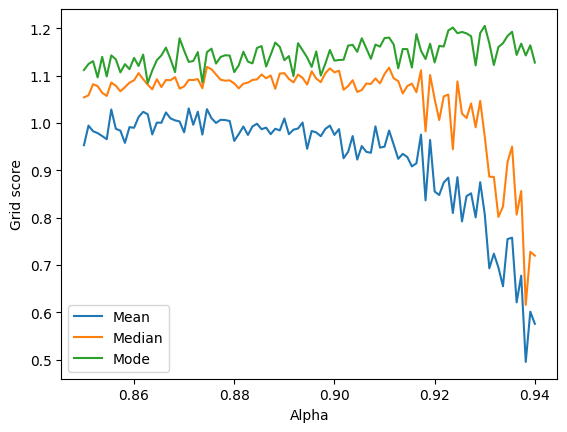

In [6]:
# NaNs to zeors
grid_scores[np.isnan(grid_scores)] = 0
grid_scores_binned = []
gs_modes = np.zeros(len(grid_scores))

gs_means = np.mean(grid_scores, axis = 1)
gs_meadians = np.median(grid_scores, axis = 1)
# mode on 30 bins
for i in range(len(grid_scores)):
    grid_scores_binned.append(np.histogram(grid_scores[i], bins = 100))
    gs_modes[i] = grid_scores_binned[i][1][np.argmax(grid_scores_binned[i][0])]
plt.plot(alphas, gs_means, label = 'Mean')
plt.plot(alphas, gs_meadians, label = 'Median')
plt.plot(alphas, gs_modes, label = 'Mode')
plt.xlabel('Alpha')
plt.ylabel('Grid score')
plt.legend()
# plt.savefig('./gridsearch/ffgc_grid_scores.png')
plt.show()

In [7]:
mode_max = alphas[np.argmax(gs_modes)]
mean_max = alphas[np.argmax(gs_means)]
median_max = alphas[np.argmax(gs_meadians)]
print(f'Mode max: {mode_max}')
print(f'Mean max: {mean_max}')
print(f'Median max: {median_max}')

Mode max: 0.9299999999999999
Mean max: 0.8709090909090909
Median max: 0.8745454545454545


C:\Users\kingt\AppData\Local\Temp\ipykernel_29876\3007076858.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(x, x/(1-x), label = 'x/(1-x)')


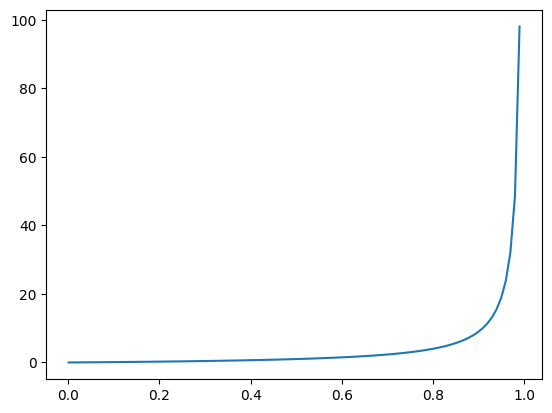

In [9]:
x = np.linspace(0.001,1,100)
plt.plot(x, x/(1-x), label = 'x/(1-x)')

In [10]:
x

array([0.001     , 0.01109091, 0.02118182, 0.03127273, 0.04136364,
       0.05145455, 0.06154545, 0.07163636, 0.08172727, 0.09181818,
       0.10190909, 0.112     , 0.12209091, 0.13218182, 0.14227273,
       0.15236364, 0.16245455, 0.17254545, 0.18263636, 0.19272727,
       0.20281818, 0.21290909, 0.223     , 0.23309091, 0.24318182,
       0.25327273, 0.26336364, 0.27345455, 0.28354545, 0.29363636,
       0.30372727, 0.31381818, 0.32390909, 0.334     , 0.34409091,
       0.35418182, 0.36427273, 0.37436364, 0.38445455, 0.39454545,
       0.40463636, 0.41472727, 0.42481818, 0.43490909, 0.445     ,
       0.45509091, 0.46518182, 0.47527273, 0.48536364, 0.49545455,
       0.50554545, 0.51563636, 0.52572727, 0.53581818, 0.54590909,
       0.556     , 0.56609091, 0.57618182, 0.58627273, 0.59636364,
       0.60645455, 0.61654545, 0.62663636, 0.63672727, 0.64681818,
       0.65690909, 0.667     , 0.67709091, 0.68718182, 0.69727273,
       0.70736364, 0.71745455, 0.72754545, 0.73763636, 0.74772

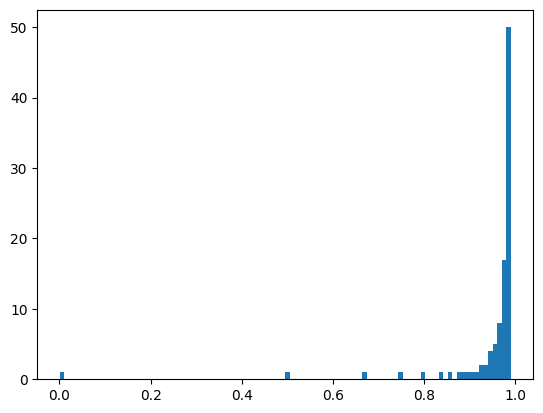

In [52]:
y = np.linspace(0.001,100,100)
alphas = 1/(1/(y) + 1)
plt.hist(alphas, bins = 100)
plt.show()

In [53]:
alphas2 = alphas[::5]
alphas

array([0.000999  , 0.50275744, 0.6690037 , 0.75193938, 0.80164097,
       0.83475047, 0.85838794, 0.87610938, 0.88988879, 0.90090983,
       0.9099254 , 0.91743725, 0.92379263, 0.92923952, 0.93395972,
       0.93808956, 0.94173328, 0.94497194, 0.94786952, 0.95047722,
       0.95283646, 0.95498113, 0.95693924, 0.95873411, 0.96038534,
       0.96190951, 0.96332074, 0.96463113, 0.96585113, 0.96698977,
       0.96805492, 0.96905349, 0.96999152, 0.97087435, 0.97170673,
       0.97249285, 0.97323647, 0.97394094, 0.97460927, 0.97524418,
       0.97584812, 0.97642328, 0.97697169, 0.97749517, 0.97799538,
       0.97847383, 0.97893193, 0.97937093, 0.979792  , 0.98019624,
       0.98058461, 0.98095805, 0.9813174 , 0.98166343, 0.98199687,
       0.98231841, 0.98262866, 0.98292821, 0.98321761, 0.98349736,
       0.98376793, 0.98402978, 0.98428331, 0.98452892, 0.98476697,
       0.9849978 , 0.98522175, 0.9854391 , 0.98565016, 0.98585518,
       0.98605443, 0.98624814, 0.98643655, 0.98661986, 0.98679

In [3]:
y

array([1.00000e-04, 1.01020e+00, 2.02030e+00, 3.03040e+00, 4.04050e+00,
       5.05060e+00, 6.06070e+00, 7.07080e+00, 8.08090e+00, 9.09100e+00,
       1.01011e+01, 1.11112e+01, 1.21213e+01, 1.31314e+01, 1.41415e+01,
       1.51516e+01, 1.61617e+01, 1.71718e+01, 1.81819e+01, 1.91920e+01,
       2.02021e+01, 2.12122e+01, 2.22223e+01, 2.32324e+01, 2.42425e+01,
       2.52526e+01, 2.62627e+01, 2.72728e+01, 2.82829e+01, 2.92930e+01,
       3.03031e+01, 3.13132e+01, 3.23233e+01, 3.33334e+01, 3.43435e+01,
       3.53536e+01, 3.63637e+01, 3.73738e+01, 3.83839e+01, 3.93940e+01,
       4.04041e+01, 4.14142e+01, 4.24243e+01, 4.34344e+01, 4.44445e+01,
       4.54546e+01, 4.64647e+01, 4.74748e+01, 4.84849e+01, 4.94950e+01,
       5.05051e+01, 5.15152e+01, 5.25253e+01, 5.35354e+01, 5.45455e+01,
       5.55556e+01, 5.65657e+01, 5.75758e+01, 5.85859e+01, 5.95960e+01,
       6.06061e+01, 6.16162e+01, 6.26263e+01, 6.36364e+01, 6.46465e+01,
       6.56566e+01, 6.66667e+01, 6.76768e+01, 6.86869e+01, 6.969

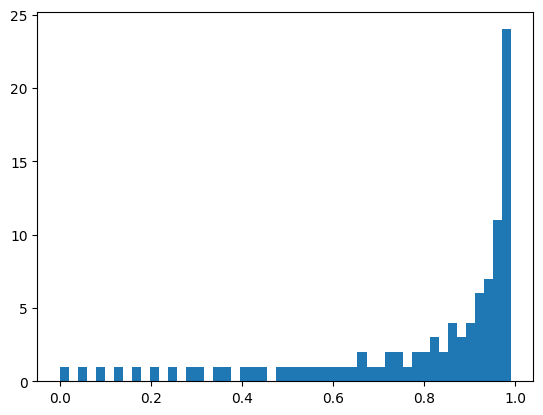

In [50]:
alphas = 1-np.geomspace(0.01,1,100)
plt.hist(alphas, bins = 50)
plt.show()

In [51]:
alphas

array([0.99      , 0.98952384, 0.98902501, 0.98850243, 0.98795496,
       0.98738143, 0.98678059, 0.98615114, 0.98549171, 0.98480089,
       0.98407717, 0.98331899, 0.98252472, 0.98169262, 0.9808209 ,
       0.97990767, 0.97895096, 0.97794869, 0.9768987 , 0.97579872,
       0.97464636, 0.97343912, 0.97217441, 0.97084947, 0.96946144,
       0.96800733, 0.96648397, 0.96488808, 0.9632162 , 0.96146471,
       0.95962983, 0.95770757, 0.95569379, 0.95358411, 0.95137398,
       0.94905862, 0.94663301, 0.9440919 , 0.94142979, 0.93864093,
       0.93571927, 0.93265849, 0.92945198, 0.92609278, 0.92257363,
       0.91888692, 0.91502466, 0.91097849, 0.90673967, 0.902299  ,
       0.8976469 , 0.89277328, 0.8876676 , 0.8823188 , 0.87671533,
       0.87084503, 0.86469522, 0.85825258, 0.85150317, 0.84443239,
       0.83702492, 0.82926474, 0.82113505, 0.81261826, 0.80369593,
       0.79434877, 0.78455653, 0.77429803, 0.76355106, 0.75229236,
       0.74049758, 0.72814118, 0.71519641, 0.70163528, 0.68742

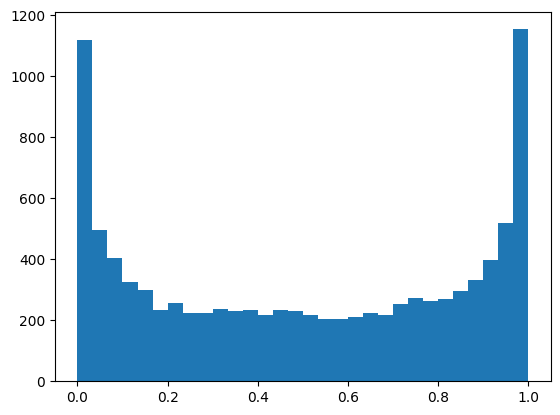

In [91]:
alphas = np.random.beta(0.5,0.5,10000)
plt.hist(alphas, bins = 30)
plt.show()

array([0.001     , 0.00112762, 0.00127046, 0.00143145, 0.00161263,
       0.00181737, 0.00204833, 0.00230808, 0.00260129, 0.00293233,
       0.00330501, 0.00372575, 0.00419986, 0.00473508, 0.00533861,
       0.00601951, 0.00678778, 0.00765519, 0.00863424, 0.0097397 ,
       0.01098817, 0.0123988 , 0.01399297, 0.01579534, 0.01783394,
       0.02014083, 0.02275278, 0.02571204, 0.02906702, 0.03287376,
       0.03719693, 0.04211158, 0.04770511, 0.05407959, 0.0613547 ,
       0.06967145, 0.07919677, 0.09012897, 0.10270503, 0.11720897,
       0.13398226, 0.15343552, 0.17606028, 0.20243703, 0.23323038,
       0.26915146, 0.31084967, 0.35867748, 0.41229392, 0.47022416,
       0.52977584, 0.58770608, 0.64132252, 0.68915033, 0.73084854,
       0.76676962, 0.79756297, 0.82393972, 0.84656448, 0.86601774,
       0.88279103, 0.89729497, 0.90987103, 0.92080323, 0.93032855,
       0.9386453 , 0.94592041, 0.95229489, 0.95788842, 0.96280307,
       0.96712624, 0.97093298, 0.97428796, 0.97724722, 0.97985

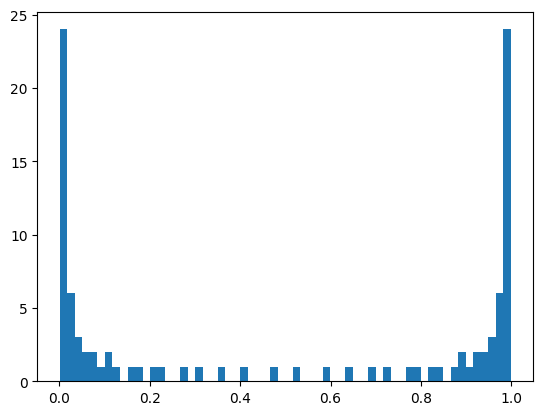

In [114]:
from scipy.integrate import cumtrapz

def inverse_transform_sampling(prob_density_func, num_samples):
    # Create an array across the interval [0, 1]
    x = np.linspace(0.001, 0.999, 10000)

    # Calculate the cumulative distribution function (CDF)
    cdf = cumtrapz(prob_density_func(x), x)
    cdf = np.insert(cdf, 0, 0)

    # Use the CDF to get the inverse CDF
    inverse_cdf = np.interp(np.linspace(0, cdf[-1], num_samples), cdf, x)

    return inverse_cdf

# alphas = inverse_transform_sampling(lambda x: 1/(x*(1-x)), 100)
alphas = inverse_transform_sampling(lambda x: (1-x)/x + x/(1-x), 100)
plt.hist(alphas, bins = 60)
alphas